In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation & Normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("✅ CIFAR-10 Dataset Loaded!")


100%|██████████| 170M/170M [2:24:18<00:00, 19.7kB/s]   


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
✅ CIFAR-10 Dataset Loaded!


In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder with Batch Normalization & Dropout
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Mean and Log Variance Layers for Latent Representation
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output [-1,1] same as input normalization
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterization(mu, logvar)
        x = self.decoder_input(z).view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar


In [3]:
def vae_loss(reconstructed_x, x, mu, logvar, beta=4):
    reconstruction_loss = nn.MSELoss()(reconstructed_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_divergence  # β-VAE modification


In [4]:
vae_model = VAE(latent_dim=100).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    vae_model.train()
    total_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed, mu, logvar = vae_model(images)
        loss = vae_loss(reconstructed, images, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/100], Loss: 528.1889
Epoch [2/100], Loss: 34.8575
Epoch [3/100], Loss: 8.3171
Epoch [4/100], Loss: 2.8222
Epoch [5/100], Loss: 1.2152
Epoch [6/100], Loss: 0.6648
Epoch [7/100], Loss: 0.4584
Epoch [8/100], Loss: 0.3618
Epoch [9/100], Loss: 0.3172
Epoch [10/100], Loss: 0.2977
Epoch [11/100], Loss: 0.2818
Epoch [12/100], Loss: 0.2744
Epoch [13/100], Loss: 0.2694
Epoch [14/100], Loss: 0.2674
Epoch [15/100], Loss: 0.2662
Epoch [16/100], Loss: 0.2636
Epoch [17/100], Loss: 0.2620
Epoch [18/100], Loss: 0.2614
Epoch [19/100], Loss: 0.2609
Epoch [20/100], Loss: 0.2606
Epoch [21/100], Loss: 0.2603
Epoch [22/100], Loss: 0.2601
Epoch [23/100], Loss: 0.2599
Epoch [24/100], Loss: 0.2596
Epoch [25/100], Loss: 0.2595
Epoch [26/100], Loss: 0.2594
Epoch [27/100], Loss: 0.2593
Epoch [28/100], Loss: 0.2595
Epoch [29/100], Loss: 0.2594
Epoch [30/100], Loss: 0.2593
Epoch [31/100], Loss: 0.2593
Epoch [32/100], Loss: 0.2592
Epoch [33/100], Loss: 0.2593
Epoch [34/100], Loss: 0.2591
Epoch [35/100], Loss

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="VAE with Regularization", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss with Regularization")
plt.legend()
plt.show()


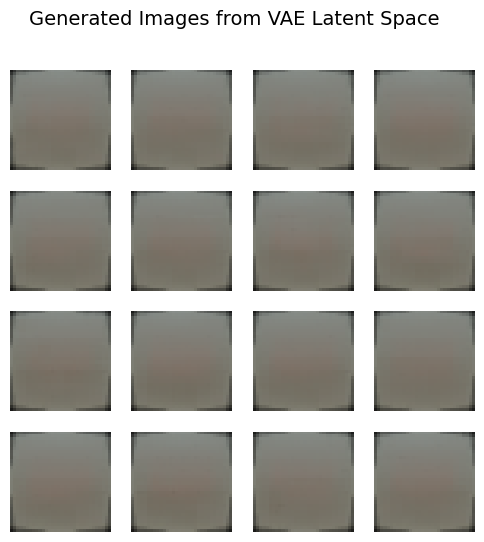

In [6]:
import numpy as np

# Generate completely new images from latent space
vae_model.eval()
num_samples = 16
random_latent_vectors = torch.randn(num_samples, 100).to(device)

with torch.no_grad():
    generated_images = vae_model.decoder_input(random_latent_vectors).view(num_samples, 128, 4, 4)
    generated_images = vae_model.decoder(generated_images).cpu()

# Plot generated images
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    img = np.transpose(generated_images[i].numpy(), (1,2,0))  # Convert CHW to HWC
    img = (img + 1) / 2  # Rescale to [0,1]
    ax.imshow(img)
    ax.axis("off")

plt.suptitle("Generated Images from VAE Latent Space", fontsize=14)
plt.show()


Implementing Standard VAE vs. Beta-VAE

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ✅ Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ✅ Define Beta-VAE Model
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=20, beta=1.0):
        super(BetaVAE, self).__init__()
        self.beta = beta  # Set β value

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# ✅ Initialize the model
latent_dim = 20  # You can experiment with different dimensions
beta_values = [0.1, 1.0, 5.0]  # Test different β values
vae_models = {beta: BetaVAE(latent_dim, beta).cuda() for beta in beta_values}

# ✅ Define loss function
def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div


Files already downloaded and verified


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# ✅ Training function
def train_beta_vae(model, beta, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.cuda()

            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = beta_vae_loss(recon_images, images, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Beta: {beta} - Loss: {avg_loss:.4f}")

    return train_losses

# ✅ Train models for different beta values
train_losses = {beta: train_beta_vae(vae_models[beta], beta, epochs=10) for beta in beta_values}


In [ ]:
# ✅ Plot loss curves for different β values
plt.figure(figsize=(8, 6))
for beta, losses in train_losses.items():
    plt.plot(losses, label=f"β = {beta}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Beta-VAE Training Loss for Different β Values")
plt.legend()
plt.show()


In [ ]:
import numpy as np

# ✅ Compare reconstructed images for different Beta-VAE models
fig, axes = plt.subplots(len(beta_values), 10, figsize=(15, 6))

with torch.no_grad():
    for row, beta in enumerate(beta_values):
        vae = vae_models[beta]
        sample_images, _ = next(iter(train_loader))
        sample_images = sample_images[:10].cuda()

        reconstructed, _, _ = vae(sample_images)

        for i in range(10):
            img = reconstructed[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
            axes[row, i].imshow(img)
            axes[row, i].axis("off")
            if i == 0:
                axes[row, i].set_title(f"β = {beta}")

plt.suptitle("Reconstruction Quality for Different β Values", fontsize=14)
plt.show()


In [ ]:
# ✅ Generate New Images for Different Beta Values
fig, axes = plt.subplots(len(beta_values), 10, figsize=(15, 6))

with torch.no_grad():
    for row, beta in enumerate(beta_values):
        vae = vae_models[beta]
        noise = torch.randn(10, latent_dim).cuda()
        generated_images = vae.decoder(noise)

        for i in range(10):
            img = generated_images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
            axes[row, i].imshow(img)
            axes[row, i].axis("off")
            if i == 0:
                axes[row, i].set_title(f"β = {beta}")

plt.suptitle("Generated Images for Different β Values", fontsize=14)
plt.show()
